In [5]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.replay_buffers import tf_uniform_replay_buffer

In [42]:
num_iterations = 5000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 10 # @param {type:"integer"}
replay_buffer_capacity = 1000 # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 100  # @param {type:"integer"}

num_eval_episodes = 20  # @param {type:"integer"}
eval_interval = 500  # @param {type:"integer"}

In [34]:
env_name = "CartPole-v0"
train_py_env = suite_gym.load(env_name)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

eval_py_env = suite_gym.load(env_name)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


In [43]:
fc_layer_params = (96, 48)
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [45]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [46]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [47]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2,
    single_deterministic_pass=False).prefetch(3)

iterator = iter(dataset)

In [48]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_env.reset()

# Create a driver to collect experience.
collect_driver = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=[replay_buffer.add_batch],
  num_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 100: loss = 18.878053665161133
step = 200: loss = 1.24805748462677
step = 300: loss = 2.0433998107910156
step = 400: loss = 7.261974334716797
step = 500: loss = 3.788455009460449
step = 500: Average Return = 59.150001525878906
step = 600: loss = 64.98619842529297
step = 700: loss = 26.495784759521484
step = 800: loss = 20.360095977783203
step = 900: loss = 61.84721374511719
step = 1000: loss = 594.809814453125
step = 1000: Average Return = 87.44999694824219
step = 1100: loss = 702.18603515625
step = 1200: loss = 9.30987548828125
step = 1300: loss = 22.97235870361328
step = 1400: loss = 648.2876586914062
step = 1500: loss = 26.476051330566406
step = 1500: Average Return = 80.0999984741211
step = 1600: loss = 1321.3763427734375
step = 1700: loss = 289.4484558105469
step = 1800: loss = 12.957220077514648
step = 1900: loss = 441.9720764160156
step = 2000: loss = 307.5409851074219
step = 2000: Average Return = 106.75
step = 2100: loss = 64.6771011352539
step = 2200: loss = 12.5572910

(-0.18249959945678818, 250.0)

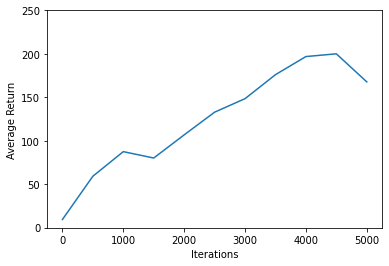

In [49]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [50]:
compute_avg_return(eval_env, agent.policy, 50)

162.64

In [51]:
from IPython.display import Video

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return Video(filename)

In [52]:
create_policy_eval_video(agent.policy, "trained-agent")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fa5c8048000] Warning: data is not aligned! This can lead to a speed loss


In [101]:
def create_policy_eval_video(policy, env, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = env.reset()
      video.append_data(tf.squeeze(env.render()).numpy())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = env.step(action_step.action)
        video.append_data(tf.squeeze(env.render()).numpy())
  return Video(filename)

In [102]:
def render_episodes(policy, env, py_env, num_episodes=5):
    for _ in range(num_episodes):
      time_step = env.reset()
      env.render(mode="human")
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = env.step(action_step.action)
        env.render(mode="human")

In [107]:
lunar_py_env = suite_gym.load("LunarLander-v2")
lunar_env = tf_py_environment.TFPyEnvironment(lunar_py_env)

In [112]:
lunar_env.time_step_spec()

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(8,), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [108]:
random_policy = random_tf_policy.RandomTFPolicy(lunar_env.time_step_spec(), lunar_env.action_spec())

In [109]:
create_policy_eval_video(random_policy, lunar_env, "lunar-lander", num_episodes=5, fps=30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fb3c8008000] Warning: data is not aligned! This can lead to a speed loss
